In [51]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from scipy import stats
import matplotlib.path as mpath
import Functions_data_analysis as fda

In [91]:
# specify reconstruction and region


pace_recon = 'PACE_super_GKO1_all_linPSM_1mc_1900_2005_GISBrom_1880_2019_v10_sst'
pace2_recon = 'PAC_PACE2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'
lme_recon = 'iCESM_LME_GKO1_linPSM_1mc_1800_2005_v10'
lens2_recon='LENS2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'

recon = lme_recon
recon_title = 'CESM1-LME'
recon_dir = 'Climate_Data/LMR_output/'

In [92]:
# Load recon psl, u, v (each has shape (n_years, n_lats, n_lons)
# Set region
region = 'South Pacific'

region_dict = {'South Pacific':[-80,-50,-160,-60]}
lat1,lat2,lon1,lon2 = region_dict[region]
#convert deg W to deg E
if lon1 < 0:
    lon1 = lon1 + 360
if lon2 < 0:
    lon2 = lon2 + 360 

recon_psl_ds = xr.open_dataset(recon_dir+recon+'_psl.nc')
recon_psl = recon_psl_ds.psl
recon_psl = recon_psl.sel(time=slice(1900,2005),lat=slice(lat1,lat2),lon=slice(lon1,lon2))
recon_psl = recon_psl.squeeze() 
recon_psl = recon_psl/100 #put in hPa

recon_u10_ds = xr.open_dataset(recon_dir+recon+'_u10.nc')
recon_u10 = recon_u10_ds.u10
recon_u10 = recon_u10.sel(time=slice(1900,2005),lat=slice(lat1,lat2),lon=slice(lon1,lon2))
recon_u10 = recon_u10.squeeze() 

recon_v10_ds = xr.open_dataset(recon_dir+recon+'_v10.nc')
recon_v10 = recon_v10_ds.v10
recon_v10 = recon_v10.sel(time=slice(1900,2005),lat=slice(lat1,lat2),lon=slice(lon1,lon2))
recon_v10 = recon_v10.squeeze() 


In [95]:
# Calculate trends

def calc_trends(recon_data):

    
    n_lats,n_lons = recon_data.shape[1:]
    years = recon_data.time
    recon_data_rs = recon_data.values.reshape(len(years),-1) #now it is shape (n_time, nlons*nlats) 
    locs = range(n_lats*n_lons)
    recon_trends = []
    for loc in locs:
        data_loc = recon_data_rs[:,loc]
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, data_loc)
        recon_trends.append(slope * 100)
    recon_trends = np.array(recon_trends)
    recon_trends = recon_trends.reshape((n_lats,-1))

    return recon_trends


psl_trends = calc_trends(recon_psl)
u10_trends = calc_trends(recon_u10)
v10_trends = calc_trends(recon_v10)
print('trends calculated')

trends calculated


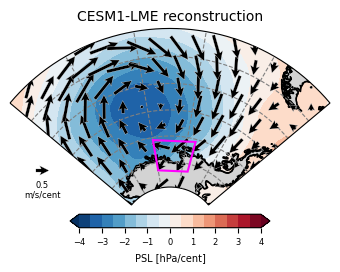

In [94]:
#Plot trends

fig = plt.figure()
fig.set_size_inches((4,3))
lon_mid = (lon1+lon2)/2
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))

# Plot SLP trends in colors
lons,lats = recon_psl.lon,recon_psl.lat
cf_em = ax.contourf(lons, lats,psl_trends,transform=ccrs.PlateCarree(),
                    levels=np.arange(-4,4.5,0.5), cmap='RdBu_r', zorder=0, extend = 'both')

# plot quivers
# # smaller scale means longer arrows. smaller regrid = fewer arrows.
quiv = ax.quiver(lons,lats, u10_trends, v10_trends,
                 transform = ccrs.PlateCarree(),regrid_shape=10,
                 pivot = 'middle',scale=12,width=0.01,
                 headlength=3,headaxislength=2.5,
                 minshaft=1,edgecolor='white',
                 linewidth = 0.2,zorder=3)
vec_len = 0.5
ax.quiverkey(quiv, X=0.1, Y=0.2, U=vec_len, label=str(vec_len)+'\nm/s/cent', labelpos='S',fontproperties={'size':6})

# # Add colorbar
cb_ax = fig.add_axes([0.3,0.13,0.5,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = 'PSL [hPa/cent]', fontsize=7)
cb_em.ax.tick_params(labelsize=6)

# # Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())
gl = ax.gridlines(color='gray', alpha=1, linestyle='--')

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='lightgray')
ax.add_feature(land)
ax.coastlines()

# add rectangle to show AS box
lat_b1,lat_b2,lon_b1,lon_b2 = fda.plot_regions['AS_near']
box = mpatches.Rectangle( (lon_b1,lat_b2), #bottom left corner (lon, lat)
                          (lon_b2+360-lon_b1+360), #width (deg lon)
                          (lat_b1-lat_b2), #high (deg lat)
                          fill=False, edgecolor='magenta', linewidth=1.5,linestyle='-',
                          transform=ccrs.PlateCarree(),zorder=3)
ax.add_patch(box)

ax.set_title(recon_title+' reconstruction', fontsize=10)
fig.subplots_adjust(left=0.15,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)

plt.savefig('Plots/Fig_Sx_Recon_ASL_trends_'+recon_title+'.png',dpi=400)